# Introduction to Alan

Alan is a probabilistic programming language that aims to provide a simple and intuitive way to perform fast Bayesian inference. In particular it is designed to showcase the "Massively Parallel" framework as outlined in [[Massively Parallel Reweighted Wake-Sleep]](https://arxiv.org/abs/2305.11022) and the source trick for computing posterior moments as outlined in [[Using autodiff to estimate posterior moments, marginals and samples]](https://arxiv.org/abs/2310.17374). This introduction assumes some prior familiarity with Bayesian inference and in particular variational Bayesian methods, for those who are not familiar with these [[Variational Inference: A Review for Statisticians]](https://arxiv.org/abs/1601.00670) gives a good overview.

# Outline
* [Introduction](#Introduction-to-Alan)
* [Setup](#Setup)
* [Background](#Background)
    * [Variational Inference](#Variational-Inference)
    * [Importance Sampling](#Importance-Sampling)
        * [Massively Parallel Importance Sampling](#Massively-Parallel-Importance-Sampling)
    * [Reweighted Wake-Sleep](#Reweighted-Wake-Sleep)
    * [Plated Models](#Plated-Models)
        * [MovieLens](#MovieLens)



# Setup

Lets get our imports out of the way first.

In [1]:
import torch as t
import torch.nn as nn
from alan import Normal, Plate, BoundPlate, Group, Problem, Data, mean, Split, OptParam, QEMParam, checkpoint, no_checkpoint, Split

import matplotlib.pyplot as plt

t.manual_seed(0)

# choose which device to use 
device = 'cpu'                    #Options cpu, cuda, mps (on an Apple M)

# The computational strategy can be set to use checkpointing (https://pytorch.org/docs/stable/checkpoint.html), 
# which can reduce memory usage at the cost of speed. We can also choose to split along a plate dimension to reduce memory usage.
computation_strategy = checkpoint #Options no_checkpoint, checkpoint, Split('p1', 3)

# Background

In the Bayesian inference framework we reason about unknown quantities, for instance the parameters of a model, by specifying a model, consisting of a prior and a likelihood, that describes how the data was generated. We then use Bayes rule to compute the posterior distribution over the unknown quantities given the data.

In general this requires an intractable expectation and so we must resort to approximations. Probabilistic programming languages provide a convenient way to specify a model and then perform inference on it. Using Alan you can specify a prior $p(\theta)$, a likelihood $p(x|\theta)$ as follows:


In [2]:
P_plate = Plate( 
    mu = Normal(0, 1),
    p1 = Plate(
        obs = Normal('mu', 1),
    ),
)

plate_sizes = {'p1': 3}
P_bound_plate = BoundPlate(P_plate, plate_sizes)

/home/thomas/anaconda3/envs/alan_simp/lib/python3.10/site-packages/torch/_tensor.py:1375: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at ../c10/core/TensorImpl.h:1907.)
  return super().rename(names)


Here ``mu = Normal(0, 1)`` corresponds the prior and ``obs = Normal('mu', 1)`` corresponds to the likelihood. So our model would look like:

$$
\begin{align}
\mu &\sim \mathcal{N}(0, 1) \\
\text{obs} &\sim \mathcal{N}(\mu, 1)
\end{align}
$$

Note that we must bind ``P_plate`` with ``BoundPlate(P_plate)`` before using it. This binds plate ``P_plate`` to plate sizes, inputs and initialises any parameters in the plate. We will see examples of all these later. For now let's sample some synthetic data from this model:

In [3]:
P_sample = P_bound_plate.sample()


Then we can perform inference in the following ways: 

1. approximate the posterior $p(\theta|x)$ using a variational approximation $q_\phi(\theta)$
2. compute importance weighted moment estimates of the posterior $p(\theta|x)$

Lets look first at variational inference.


## Variational Inference

Variational inference is a method for approximating the posterior distribution $p(\theta|x)$ by finding the member of a family of distributions $q_\phi(\theta)$ that is closest to the posterior in terms of the KL-divergence between them.

Our approximate posterior is a member of a family of distributions $q_\phi(\theta)$ parameterised by $\phi$. We can then find the optimal parameters $\phi^*$ by minimising the KL-divergence between the approximate posterior and the true posterior:
$$
\begin{align}
\phi^* &= \arg\min_\phi \text{KL}(q_\phi(\theta)||p(\theta|x)) \\
&= \arg\min_\phi \mathbb{E}_{q_\phi(\theta)}\left[\log q_\phi(\theta) - \log p(\theta|x)\right] \\
&= \arg\min_\phi \mathbb{E}_{q_\phi(\theta)}\left[\log q_\phi(\theta) - \log p(x|\theta) - \log p(\theta)\right] \\
\end{align}
$$

In Alan we can define a variational distribution by specifying the type of distribution we want to use and the parameters of that distribution as follows:


In [4]:
Q_plate = Plate( 
    mu = Normal(OptParam(0.), OptParam(1.)),
    p1 = Plate(
        obs = Data(),
    ),
)

Q_bound_plate = BoundPlate(Q_plate, plate_sizes)

This corresponds to a normal distribution with mean $\mu$ and standard deviation $\sigma$, initialised as $\mu_0 = 0, \sigma_0 = 0$. Note again that we need to bind ``Q_plate`` with ``BoundPlate(Q_plate)`` before using it. Note also that Q_plate must have the same plates as P_plate, and that we use the ``Data`` class to indicate non-latents.

Then we can define an Alan "problem" conditioned on the synthetic data from above:

In [5]:
data = {'obs': P_sample['obs']}

problem = Problem(P_bound_plate, Q_bound_plate, data)
#Move problem to the device.
problem.to(device=device)

Problem(
  (P): BoundPlate(
    (_inputs): BufferStore()
    (_opt_params): ParameterStore()
    (_qem_params): BufferStore()
    (_qem_means): BufferStore()
    (_dists): ModuleStore(
      (mu): Dist(
        (tensor_args): BufferStore()
      )
      (obs): Dist(
        (tensor_args): BufferStore()
      )
    )
  )
  (Q): BoundPlate(
    (_inputs): BufferStore()
    (_opt_params): ParameterStore()
    (_qem_params): BufferStore()
    (_qem_means): BufferStore()
    (_dists): ModuleStore(
      (mu): Dist(
        (tensor_args): BufferStore()
      )
    )
  )
  (_data): BufferStore()
)

We can find the optimal parameters of the variational distribution by minimising the KL divergence between the variational distribution and the posterior using gradient descent. In Alan we do this as follows:

In [6]:
opt = t.optim.Adam(problem.parameters(), lr=1e-3)

K=1
print("K={}".format(K))
for i in range(1000):
    opt.zero_grad()
    sample = problem.sample(K=K)
    elbo = sample.elbo_vi(computation_strategy=computation_strategy)
    elbo.backward()
    opt.step()

    if 0 == i%200:
        print(elbo.item())

K=1
-15.279102325439453
-6.616936683654785
-2.8634040355682373
-4.374089241027832
-3.4545838832855225


## Importance Sampling

Above you will notice that we define $K=1$. In Alan we use importance weighted estimates of the log marginal likelihood to calculate our objectives and other terms of interest. This means that we draw samples from our approximate posterior and then weight them by the ratio of the posterior and the variational distribution. We can write the evidence lower bound (ELBO) in the single sample setting as follows:

$$
\begin{align}
\log p(x) &= \log \mathbb{E}_{q_\phi(\theta)}\left[\frac{p(x, \theta)}{q_\phi(\theta)}\right] \\
&\geq \mathbb{E}_{q_\phi(\theta)}\left[ \log \frac{p(x, \theta)}{q_\phi(\theta)}\right] \\
&= \mathbb{E}_{q_\phi(\theta)}\left[ \log \mathcal{P} \right]
\end{align}
$$

Where $\log \mathcal{P} = \log \frac{p(x, \theta)}{q_\phi(\theta)}$ is an unbiased estimate of the log marginal likelihood (when samples are drawn from $q_\phi(\theta)$). We can then recover a number of methods of interest by making difference choices of $\mathcal{P}$. For instance, we can recover the [[Importance weighted autoencoder]](https://arxiv.org/pdf/1509.00519.pdf) lower bound by taking multiple importance samples to obtain a better estimate of the log marginal likelihood like so:

$$
\begin{align}
\log p(x) &\geq \mathbb{E}_{\theta_k \sim q_\phi(\theta)}\left[ \log \frac{1}{K}\sum_{k=1}^K \frac{p(x, \theta_k)}{q_\phi(\theta_k)} \right] \\
&= \mathbb{E}_{q_\phi(\theta)}\left[ \log \mathcal{P_{\text{IW}}} \right] \\
\end{align}
$$


### Massively Parallel Importance Sampling

If we instead draw $K$ samples of each latent variable ($n$) Alan, and its massively parallel estimates of the log marginal likelihood, can be used to reason about all $K^n$ combinations of samples. To ease thinking about this, we denote the collection of K samples for latent $i$ as 

$$ 
z_i = \{z_{i}^1, z_{i}^2, \dots, z_{i}^K\} \in \mathcal{Z}_i^K
$$

We sample these from IID distributions over the samples:

$$
Q_\text{MP}(z|x) = \prod_{i=1}^n Q_\text{MP}(z_i|z_j \text{ for all } j \in \text{qa}(i))
$$

where $\text{qa}(i)$ denotes the parents of $z_i$ in the approximate posterior. We can choose how to construct $Q_\text{MP}$, each choice being a different way of mixing across parent particles. More details can be found in appendix B of [[Massively Parallel Reweighted Wake-Sleep]](https://arxiv.org/abs/2305.11022).

This construction should result in tighter evidence lower bounds in VI and better estimates of the posterior in sampling. In Alan we can perform massively parallel importance sampling VI as follows:

In [7]:
opt = t.optim.Adam(problem.parameters(), lr=1e-3)

K=20
print("K={}".format(K))
for i in range(1000):
    opt.zero_grad()
    sample = problem.sample(K=K)
    elbo = sample.elbo_vi(computation_strategy=computation_strategy)
    elbo.backward()
    opt.step()

    if 0 == i%200:
        print(elbo.item())

K=20
-3.6262998580932617
-3.5933971405029297
-3.236876964569092
-3.9943041801452637
-3.8651158809661865


## (Massively Parallel) Reweighted Wake-Sleep

[[Reweighted wake-sleep]](https://arxiv.org/abs/1406.2751) is a generalisation of [[wake-sleep]](https://www.mitpressjournals.org/doi/abs/10.1162/neco.1995.7.3.445): a two phase inference method for generative models and approximate posteriors. In particular, since reparaterisation is not required, it can be used with discrete latent variables.

Unlike variational inference, reweighted wake-sleep doesn't have a unified objective. Instead it updates the parameters of the generative model and the approximate posterior with two different updates. In an ideal world where we had access to the true posterior we would perform:

$$
\begin{align}
  \Delta \theta_\text{post} &= \mathbb{E}_{P_\theta(z^k| x)}[\nabla_\theta \log P_\theta(z, x)]\\
  \Delta \phi_\text{post} &= \mathbb{E}_{P_\theta(z^k| x)}[\nabla_\phi   \log Q_\phi(z| x)]
\end{align}
$$

The update for the parameters of P is the M-step in EM, and the update for the parameters of Q is maximum likelihood using samples from the true posterior.

Since we don't have access to the true posterior we can sample from the approximate posterior and perform importance weighting. Noting that both of these updates are expectations under the approximate posterior we can write them in the form $\Delta_\text{post} = \mathbb{E}_{P_\theta(z^k| x)}[\Delta(z^k)]$ and thus we get:

$$
\begin{align}
\Delta_\text{post} = \mathbb{E}_{Q_\phi(z^k| x)}\left[\frac{P_\theta(z^k| x)}{Q_\phi(z^k| x)}\Delta(z^k)\right]
\end{align}
$$

But since $P_\theta(z^k| x) = \frac{P_\theta(z^k, x)}{P_\theta(x)}$, and we can't usually compute $P_\theta(x)$, we can instead use the unbiased importance weighting estimate of $P_\theta(x)$ from earlier:

$$
\begin{align}
\Delta_\text{post} = \mathbb{E}_{Q_\phi(z^k| x)}\left[\frac{\frac{P_\theta(z^k, x)}{Q_\phi(z^k| x)}}{P_\text{IW}}\Delta(z^k)\right]
\end{align}
$$

And with a bit more tricky algebra we could also use the massively parallel importance sampling estimate of the log marginal likelihood:

$$
\begin{align}
\Delta_\text{post} = \mathbb{E}_{Q_\phi(z^k| x)}\left[\frac{\frac{P_\theta(z^k, x)}{\prod_i Q(z_i^{k_i}| x, z_{\text{qa}(i)})}}{P_\text{MP}}\Delta(z^k)\right]
\end{align}
$$

To perform Massively Parallel Reweighted Wake-Sleep in Alan we can do the following:

In [8]:
rws_Q_opt = t.optim.Adam(problem.Q.parameters(), lr=0.01, maximize=False)

K=20
print("K={}".format(K))
for i in range(1000):
    rws_Q_opt.zero_grad()
    sample = problem.sample(K=K)
    rws = sample.elbo_rws(computation_strategy=computation_strategy)
    rws.backward()
    rws_Q_opt.step()

    if 0 == i%200:
        print(rws.item())

K=20
-3.9689669609069824
-3.559515953063965
-3.5540452003479004
-3.533034324645996
-3.551379680633545


# Plated Models

Now that we have a basic idea of how Alan works, lets try making our models more complex. In particular, lets try to model some data that has a heirarchical structure. 

## MovieLens

The [[MovieLens-100k dataset]](https://grouplens.org/datasets/movielens/100k/) consists of 100,000 movie ratings from 1000 users on 1700 movies. Each film, indexed $j$ has a vector of genre tags $x_j$. We observe user ratings $y_{mj}$ for each user $m$ and film $j$ and binarise them according to ${0,1,2,3} \rightarrow 0$ and ${4,5} \rightarrow 1$ to get $\mathrm{Rating}_{mj}$.

We can model this data using a hierarchical bayesian model as so:

$$
\begin{align}
\nonumber
\boldsymbol{\mu} &\sim \mathcal{N}(\mathbf{0}_{18},1) \\
\nonumber
\psi &\sim \operatorname{Categorical}([0.1,0.5,0.4,0.05,0.05]) \\
\nonumber
\mathbf{z}_m &\sim \mathcal{N}(\boldsymbol{\mu},\exp(\psi) \mathbf{I}), \ m=1,\dotsc,M \\
\mathrm{Rating}_{mj} &\sim \operatorname{Bernoulli}(\sigma(\mathbf{z}_m^\intercal \mathbf{x}_j)), \ j=1,\dotsc,\mathrm{N}
\end{align}
$$

First we get our data, the data must be appropriately named according to the plate names in the model:

In [9]:
M=450
N=20

sizes = {'Users':M, 'Films':N}
d_z = 18

covariates = {'x':t.load('movielens_data/weights_{0}_{1}.pt'.format(N, M))}
test_covariates = {'x':t.load('movielens_data/test_weights_{0}_{1}.pt'.format(N, M))}
all_covariates = {'x': t.cat([covariates['x'],test_covariates['x']],-2).rename('Users','Films',...)}
covariates['x'] = covariates['x'].rename('Users','Films',...)
test_covariates['x'] = test_covariates['x'].rename('Users','Films',...)


data = {'obs':t.load('movielens_data/data_y_{0}_{1}.pt'.format(N, M))}
test_data = {'obs':t.load('movielens_data/test_data_y_{0}_{1}.pt'.format(N, M))}
all_data = {'obs': t.cat([data['obs'],test_data['obs']], -1).rename('Users','Films')}
data['obs'] = data['obs'].rename('Users','Films')
test_data['obs'] = test_data['obs'].rename('Users','Films')

Then we can define our model:

In [11]:
from alan import Bernoulli

P = Plate(
        mu_z = Normal(t.zeros((d_z,)), t.ones((d_z,))),
        psi_z = Normal(t.zeros((d_z,)), t.ones((d_z,))),
        Users = Plate(
            z = Normal("mu_z", lambda psi_z: psi_z.exp()),
            Films = Plate(
                obs = Bernoulli(logits = lambda z, x: z @ x),
            )
        ),
    )

P = BoundPlate(P, sizes, inputs = covariates)

Q = Plate(
    mu_z = Normal("mu_z_loc", "mu_z_scale"),
    psi_z = Normal("psi_z_loc", "psi_z_scale"),
    Users = Plate(
        z = Normal("z_loc", "z_scale"),

        Films = Plate(
            obs = Data()
        )
    ),
)

Q = BoundPlate(Q, sizes, inputs = covariates,
                extra_opt_params = {"mu_z_loc":   t.zeros((d_z,)), 
                                    "mu_z_scale": t.ones((d_z,)),
                                    "psi_z_loc":   t.zeros((d_z,)), 
                                    "psi_z_scale": t.ones((d_z,)),
                                    "z_loc":   t.zeros((M, d_z), names=('Users', None)),
                                    "z_scale": t.ones((M, d_z), names=('Users', None))})

Now we can run inference:

In [13]:
prob = Problem(P, Q, data)
prob.to(device)

elbos = []
opt = t.optim.Adam(prob.Q.parameters(), lr=1e-3)

K=20
print("K={}".format(K))
for i in range(2000):
    opt.zero_grad()
    sample = prob.sample(K=K)
    elbo = sample.elbo_vi(computation_strategy=computation_strategy)
    elbo.backward()
    opt.step()

    elbos.append(elbo.item())
    if 0 == i%200:
        print(elbo.item())

K=20


RuntimeError: aten::lerp_.Scalar is not yet supported with named tensors. Please drop names via `tensor = tensor.rename(None)`, call the op with an unnamed tensor, and set names on the result of the operation.

And lets look at the results:

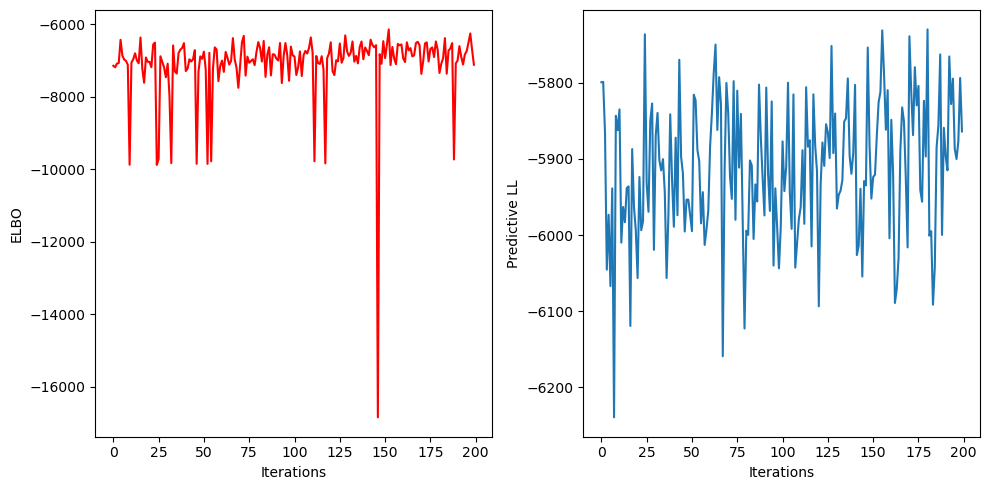

In [ ]:
#plotting elbos and predictive lls in a single figure

fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].plot(elbos, c='red')
ax[0].set_xlabel('Iterations')
ax[0].set_ylabel('ELBO')

# ax[1].plot(pred_lls)
# ax[1].set_xlabel('Iterations')
# ax[1].set_ylabel('Predictive LL')

plt.tight_layout()
plt.show()


Note how we compute predictive log likelihoods:

tensor(-5844.3090, dtype=torch.float64)

# MP Importance Weighted Moment Estimates

We can also use Alan to compute importance weighted moment estimates of the posterior. This is useful for computing things like the posterior mean and variance and can be used directly in a Bayesian workflow or for the initialisation of MCMC or a variational posterior for instance. First define a model and some data:

In [18]:
P = Plate(
    ab = Group(
        a = Normal(0, 1),
        b = Normal("a", 1),
    ),
    c = Normal(0, lambda a: a.exp()),
    p1 = Plate(
        d = Normal("a", 1),
        p2 = Plate(
            e = Normal("d", 1.),
        ),
    ),
)

Q = Plate(
    ab = Group(
        a = Normal("a_mean", 1),
        b = Normal("a", 1),
    ),
    c = Normal(0, lambda a: a.exp()),
    p1 = Plate(
        d = Normal("d_mean", 1),
        p2 = Plate(
            e = Data()
        ),
    ),
)

platesizes = {'p1': 3, 'p2': 4}
data = {'e': t.randn(3, 4, names=('p1', 'p2'))}

P = BoundPlate(P, platesizes)
Q = BoundPlate(Q, platesizes, extra_opt_params={'a_mean': t.zeros(()), 'd_mean':t.zeros(3, names=('p1',))})

prob = Problem(P, Q, data)

# Get some initial samples (with K=3 dims)
sample = prob.sample(3, True)

Then we can compute some posterior moments:

In [19]:
#Import some moment functions, mean, variance and mean squared
from alan import mean, var, mean2

#We can compute moments in three ways:

#By computing the posterior marginals and using these to compute the moments 
marginals = sample.marginals()
marginal_moments = marginals.moments([('d', mean), ('d', mean2), ('c', mean2), ('c', var)])

#By computing moments using the source term trick from approximate posterior samples
moments = sample.moments((('d', mean), ('d', mean2), ('c', mean2)))

#By drawing importance samples and using these to compute the moments
importance_samples = sample.importance_sample(N=1000)
posterior_moments = importance_samples.moments((('d', mean), ('d', mean2), ('c', mean2)))


# Models where both P and Q have parameters

In many cases (such as the VAE) both $P$ and $Q$ have parameters we wish to learn. We may also wish to learn some parameters using an expectation maximisation scheme, whilst also learning the others using VI or RWS. 

First we need to define a model, specifying if a parameter is to be learnt using an optimiser (using ``OptParam``) or not (using ``QEMParam``). We specify the initial values of our parameters as arguments to the ``OptParam`` and ``QEMParam`` classes. We can also specify learnable params as strings, but must then specify the initial values in ``extra_opt_params``. 

In [ ]:
P_plate = Plate( 
    a = Normal(OptParam(0., name='a_loc_P'), 1),
    bc = Group(
        b = Normal('a', 1),
        c = Normal('b', 1),
    ),
    d = Normal(0, lambda c: c.exp()),
    p1 = Plate(
        e = Normal("d", 1),
        p2 = Plate(
            f = Normal("e", 1.),
        ),
    ),
)

Q_plate = Plate( 
    a = Normal(QEMParam(0.), QEMParam(1.)),
    bc = Group(
        b = Normal(QEMParam(0.), QEMParam(1.)),
        c = Normal('c_loc', lambda c_log_scale: c_log_scale.exp())
    ),
    d = Normal(0, lambda c: c.exp()),
    p1 = Plate(
        e = Normal(QEMParam(0.), QEMParam(1.)),
        p2 = Plate(
            f = Data(),
        ),
    ),
)

all_platesizes = {'p1': 4, 'p2': 6}
extra_opt_params = {'c_loc': t.zeros(()), 'c_log_scale': t.zeros(())}

P_bound_plate = BoundPlate(P_plate, all_platesizes)
Q_bound_plate = BoundPlate(Q_plate, all_platesizes, extra_opt_params=extra_opt_params)

P_sample = P_bound_plate.sample()
data = {'f': P_sample['f']}

problem = Problem(P_bound_plate, Q_bound_plate, data)
#Move problem to the device.
problem.to(device=device)

We can then run inference with the previously discussed methods:

In [ ]:
sample = problem.sample(K=10)

#Update QEM Params
sample.update_qem_params(0.1, computation_strategy=computation_strategy)

#Update Opt Params using VI
vi_opt = t.optim.Adam(problem.parameters(), lr=0.01, maximize=True)

sample.elbo_vi(computation_strategy=computation_strategy).backward()
vi_opt.step()
vi_opt.zero_grad()



#Update Opt Params using RWS.
rws_P_opt = t.optim.Adam(problem.P.parameters(), lr=0.01, maximize=True)
rws_Q_opt = t.optim.Adam(problem.Q.parameters(), lr=0.01, maximize=False)

sample.elbo_rws(computation_strategy=computation_strategy).backward()
rws_P_opt.step()
rws_Q_opt.step()

rws_P_opt.zero_grad()
rws_Q_opt.zero_grad()

## Next Steps

The API documentation can be found at [alan.readthedocs.io](https://alan.readthedocs.io/en/latest/). The source code can be found at [github.com/pyro-ppl/alan](https://github.com/pyro-ppl/alan).

Further examples can be found at [Examples](https://alan.readthedocs.io/en/latest/examples).